# Analysis examples

In [1]:
import os
import glob
from collections import defaultdict


In [2]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt


In [26]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In this notebook we'll show examples of how you might use the predictions exported from SLEAP. We'll work with an [Analysis HDF5](https://sleap.ai/tutorials/analysis.html) file (rather than the `.slp` predictions file). This HDF5 file can be exported from SLEAP.

We advise building your post-SLEAP analysis pipeline around these HDF5 files rather than trying to work directly with the `.slp` files used by SLEAP.

**Note**: You can work with these HDF5 directly in Python (as we'll do here) or MATLAB without having SLEAP itself installed.

We can set the path and filename to the analysis HDF5. In our case, this is just `predictions.analysis.h5`. If you're running analysis code on your local computer this will be the full path and filename of your HDF5. If you're running analysis code on Colab, then you'll probably copy files to Colab via Google Drive and should use the path to your file there.

# Reading in the CS Tone spreadsheet

In [34]:
tone_df = pd.read_csv("./proc/20221125_144832_omission_subject_6_1_top_1_base_2_merged.timestamps.csv", index_col=0)

In [41]:
tone_df["20_second_before"] = tone_start_only_df["filled_frame_number"] - 30 * 5
tone_df["20_second_after"] = tone_start_only_df["filled_frame_number"] + 30 * 5

In [36]:
tone_df.tail()

,voltage_time_stamp,frame_number,PosTimestamp,video_time,video_seconds,filled_voltage_time_stamp,filled_frame_number,filled_PosTimestamp,filled_video_time,filled_video_seconds,time,state,trial_number,filled_state,filled_trial_number
25388554,29063065,NaN,NaN,NaN,NaN,29063065,25335.0,29061683.0,1809.642857,1809.0,NaN,NaN,NaN,1.0,16.0
25388555,29063066,NaN,NaN,NaN,NaN,29063066,25335.0,29061683.0,1809.642857,1809.0,NaN,NaN,NaN,1.0,16.0
25388556,29063067,NaN,NaN,NaN,NaN,29063067,25335.0,29061683.0,1809.642857,1809.0,NaN,NaN,NaN,1.0,16.0
25388557,29063068,NaN,NaN,NaN,NaN,29063068,25335.0,29061683.0,1809.642857,1809.0,NaN,NaN,NaN,1.0,16.0
25388558,29063069,NaN,NaN,NaN,NaN,29063069,25335.0,29061683.0,1809.642857,1809.0,NaN,NaN,NaN,1.0,16.0


In [42]:
tone_start_only_df = tone_df.dropna(subset="state").reset_index(drop=True)

In [43]:
tone_start_only_df

,voltage_time_stamp,frame_number,PosTimestamp,video_time,video_seconds,filled_voltage_time_stamp,filled_frame_number,filled_PosTimestamp,filled_video_time,filled_video_seconds,time,state,trial_number,filled_state,filled_trial_number,20_second_before,20_second_after
0,3680870,NaN,NaN,NaN,NaN,3680870,NaN,NaN,NaN,NaN,3680870.0,1.0,1.0,1.0,1.0,NaN,NaN
1,3825268,NaN,NaN,NaN,NaN,3825268,145.0,3824999.0,10.357143,10.0,3825268.0,0.0,1.0,0.0,1.0,-5.0,295.0
2,5025667,NaN,NaN,NaN,NaN,5025667,1343.0,5025162.0,95.928571,95.0,5025667.0,1.0,2.0,1.0,2.0,1193.0,1493.0
3,5225666,NaN,NaN,NaN,NaN,5225666,1542.0,5224727.0,110.142857,110.0,5225666.0,0.0,2.0,0.0,2.0,1392.0,1692.0
4,6625665,NaN,NaN,NaN,NaN,6625665,2939.0,6624455.0,209.928571,209.0,6625665.0,1.0,3.0,1.0,3.0,2789.0,3089.0
5,6825665,NaN,NaN,NaN,NaN,6825665,3140.0,6825406.0,224.285714,224.0,6825665.0,0.0,3.0,0.0,3.0,2990.0,3290.0
6,8425664,NaN,NaN,NaN,NaN,8425664,4736.0,8424700.0,338.285714,338.0,8425664.0,1.0,4.0,1.0,4.0,4586.0,4886.0
7,8625663,NaN,NaN,NaN,NaN,8625663,4937.0,8625651.0,352.642857,352.0,8625663.0,0.0,4.0,0.0,4.0,4787.0,5087.0
8,10025660,NaN,NaN,NaN,NaN,10025660,6334.0,10025379.0,452.428571,452.0,10025660.0,1.0,5.0,1.0,5.0,6184.0,6484.0
9,10225662,NaN,NaN,NaN,NaN,10225662,6533.0,10224944.0,466.642857,466.0,10225662.0,0.0,5.0,0.0,5.0,6383.0,6683.0


# Getting the coordinates of the 4 corners and the reward port

In [7]:
filename = "./predictions/orientation_20221125_144832_omission_and_competition_subejct_6_1_and_6_2.1.fixed.round_4.predictions.analysis.h5"

## Loading the data

We use the [h5py](https://www.h5py.org) package to load data from the HDF5. This is already installed in Colab. If your running analysis code on your local machine and have SLEAP installed, then `h5py` and other packages we use are already installed in your SLEAP conda environment. Otherwise, you may need to use `conda` or `pip` to install `h5py` as well as `numpy`, `scipy`, `matplotlib`, `seaborn`, and any other packages you want use in your analysis code.

Let's load the file and take a peek.

In [8]:
import h5py
import numpy as np

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()


===filename===
./predictions/orientation_20221125_144832_omission_and_competition_subejct_6_1_and_6_2.1.fixed.round_4.predictions.analysis.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(17946, 9, 2, 1)

===nodes===
0: reward_port
1: box_top_left
2: box_top_right
3: box_bottom_left
4: box_bottom_right
5: video_top_right
6: video_top_left
7: video_bottom_right
8: video_bottom_left



In our example file, the shape of the locations matrix (the `tracks` dataset) is (3000, 13, 2, 2) **after it is transposed** (with the `.T`). We transpose the data when loading it in Python; no transpose is needed when using MATLAB. This is because Python and MATLAB expect matrices to be stored differently.

Here's what each dimension of the matrix means:

- 3000: the number of frames;

- 13: the number of nodes in the skeleton (we've also loaded and displayed the `node_names` dataset with the names of these 13 nodes);

- 2: for the x and y coordinates;

- 2: the number of distinct animal identities which were found (we have 2 flies in the video clip and they were tracked perfectly, so we ended up with exactly 2 track, but there may be more tracks than animals if tracking didn't work as well).

We can get these counts from the shape of the matrix, like so:


In [9]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

frame count: 17946
node count: 9
instance count: 1


In [10]:
corner_locations = locations[0,:,:,:]

In [11]:
corner_locations

array([[[ 968.26515974],
        [ 907.14479439]],

       [[ 755.2509712 ],
        [ 266.24712379]],

       [[1222.84983662],
        [ 278.00031358]],

       [[ 720.34187828],
        [ 860.34669824]],

       [[1237.4059467 ],
        [ 887.33905551]],

       [[1540.41525426],
        [   0.        ]],

       [[ 383.2257975 ],
        [   5.90701579]],

       [[1552.25474786],
        [1080.        ]],

       [[ 393.25450823],
        [1080.        ]]])

In [12]:
corner_locations[0][0]

array([968.26515974])

In [13]:
node_names

['reward_port',
 'box_top_left',
 'box_top_right',
 'box_bottom_left',
 'box_bottom_right',
 'video_top_right',
 'video_top_left',
 'video_bottom_right',
 'video_bottom_left']

In [14]:
node_name_to_coordinates = {name: coordinate for name, coordinate in zip(node_names, corner_locations)}

In [15]:
node_name_to_coordinates

{'reward_port': array([[968.26515974],
        [907.14479439]]),
 'box_top_left': array([[755.2509712 ],
        [266.24712379]]),
 'box_top_right': array([[1222.84983662],
        [ 278.00031358]]),
 'box_bottom_left': array([[720.34187828],
        [860.34669824]]),
 'box_bottom_right': array([[1237.4059467 ],
        [ 887.33905551]]),
 'video_top_right': array([[1540.41525426],
        [   0.        ]]),
 'video_top_left': array([[383.2257975 ],
        [  5.90701579]]),
 'video_bottom_right': array([[1552.25474786],
        [1080.        ]]),
 'video_bottom_left': array([[ 393.25450823],
        [1080.        ]])}

In [16]:
corner_to_color = {"reward_port": "orange", "top_right": "red", "top_left": "yellow", "bottom_right": "green", "bottom_left": "blue"}

Text(0.5, 1.0, 'Location of each corner in Reward Competition')

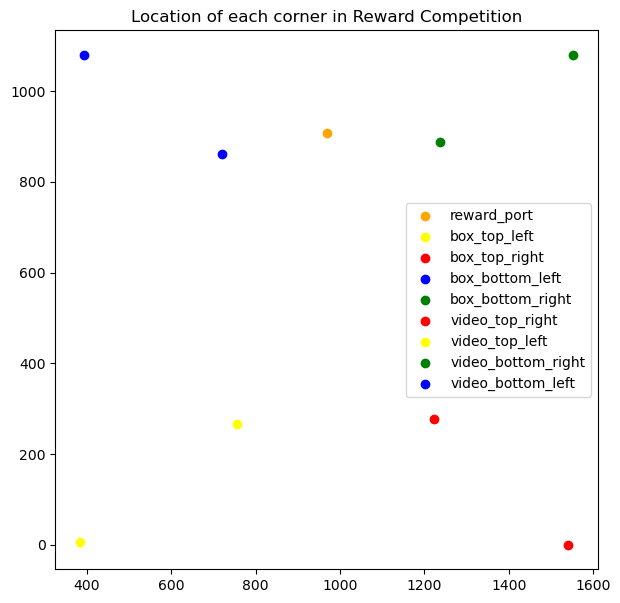

In [17]:
plt.figure(figsize=(7,7))

for name, coordinate in node_name_to_coordinates.items():
    corner_direction = name.strip("box").strip("video").strip("_")
    plt.scatter(coordinate[0], coordinate[1], label=name, c=corner_to_color[corner_direction])


plt.legend()

plt.title('Location of each corner in Reward Competition')

# Getting the coordinates of each mouse to the reward port

In [18]:
filename = "./predictions/20221125_144832_omission_and_competition_subejct_6_1_and_6_2.1.fixed.round_4.predictions.analysis.h5"

## Loading the data

We use the [h5py](https://www.h5py.org) package to load data from the HDF5. This is already installed in Colab. If your running analysis code on your local machine and have SLEAP installed, then `h5py` and other packages we use are already installed in your SLEAP conda environment. Otherwise, you may need to use `conda` or `pip` to install `h5py` as well as `numpy`, `scipy`, `matplotlib`, `seaborn`, and any other packages you want use in your analysis code.

Let's load the file and take a peek.

In [19]:
with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]
    track_names = f["track_names"][:].T
    track_names = [str(name.decode('UTF-8')) for name in track_names]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()


===filename===
./predictions/20221125_144832_omission_and_competition_subejct_6_1_and_6_2.1.fixed.round_4.predictions.analysis.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(25336, 6, 2, 1)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [20]:
track_names

['track_0']

In our example file, the shape of the locations matrix (the `tracks` dataset) is (3000, 13, 2, 2) **after it is transposed** (with the `.T`). We transpose the data when loading it in Python; no transpose is needed when using MATLAB. This is because Python and MATLAB expect matrices to be stored differently.

Here's what each dimension of the matrix means:

- 3000: the number of frames;

- 13: the number of nodes in the skeleton (we've also loaded and displayed the `node_names` dataset with the names of these 13 nodes);

- 2: for the x and y coordinates;

- 2: the number of distinct animal identities which were found (we have 2 flies in the video clip and they were tracked perfectly, so we ended up with exactly 2 track, but there may be more tracks than animals if tracking didn't work as well).

We can get these counts from the shape of the matrix, like so:


In [21]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

frame count: 25336
node count: 6
instance count: 1


Now that we've loaded the data, let's see some different things we can do with it...

## Fill missing values

In [22]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [23]:
locations = fill_missing(locations)

## Visualize thorax movement across video

In [27]:
node_names

['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']

In [28]:
body_part_to_loc = {}
for index, body_part in enumerate(node_names):
    body_part_to_loc[body_part] = locations[:, index, :, :]

In [29]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

### SLEAP Coordinates


In [30]:
body_part_to_loc["thorax"]

array([[[1228.16040039],
        [ 843.96142578]],

       [[1228.16040039],
        [ 843.96142578]],

       [[1228.16040039],
        [ 843.96142578]],

       ...,

       [[ 959.8237915 ],
        [ 791.78588867]],

       [[ 948.15484619],
        [ 788.296875  ]],

       [[ 948.15783691],
        [ 788.29571533]]])

In [44]:
tone_start_only_df

,voltage_time_stamp,frame_number,PosTimestamp,video_time,video_seconds,filled_voltage_time_stamp,filled_frame_number,filled_PosTimestamp,filled_video_time,filled_video_seconds,time,state,trial_number,filled_state,filled_trial_number,20_second_before,20_second_after
0,3680870,NaN,NaN,NaN,NaN,3680870,NaN,NaN,NaN,NaN,3680870.0,1.0,1.0,1.0,1.0,NaN,NaN
1,3825268,NaN,NaN,NaN,NaN,3825268,145.0,3824999.0,10.357143,10.0,3825268.0,0.0,1.0,0.0,1.0,-5.0,295.0
2,5025667,NaN,NaN,NaN,NaN,5025667,1343.0,5025162.0,95.928571,95.0,5025667.0,1.0,2.0,1.0,2.0,1193.0,1493.0
3,5225666,NaN,NaN,NaN,NaN,5225666,1542.0,5224727.0,110.142857,110.0,5225666.0,0.0,2.0,0.0,2.0,1392.0,1692.0
4,6625665,NaN,NaN,NaN,NaN,6625665,2939.0,6624455.0,209.928571,209.0,6625665.0,1.0,3.0,1.0,3.0,2789.0,3089.0
5,6825665,NaN,NaN,NaN,NaN,6825665,3140.0,6825406.0,224.285714,224.0,6825665.0,0.0,3.0,0.0,3.0,2990.0,3290.0
6,8425664,NaN,NaN,NaN,NaN,8425664,4736.0,8424700.0,338.285714,338.0,8425664.0,1.0,4.0,1.0,4.0,4586.0,4886.0
7,8625663,NaN,NaN,NaN,NaN,8625663,4937.0,8625651.0,352.642857,352.0,8625663.0,0.0,4.0,0.0,4.0,4787.0,5087.0
8,10025660,NaN,NaN,NaN,NaN,10025660,6334.0,10025379.0,452.428571,452.0,10025660.0,1.0,5.0,1.0,5.0,6184.0,6484.0
9,10225662,NaN,NaN,NaN,NaN,10225662,6533.0,10224944.0,466.642857,466.0,10225662.0,0.0,5.0,0.0,5.0,6383.0,6683.0


Text(0.5, 1.0, 'Thorax locations')

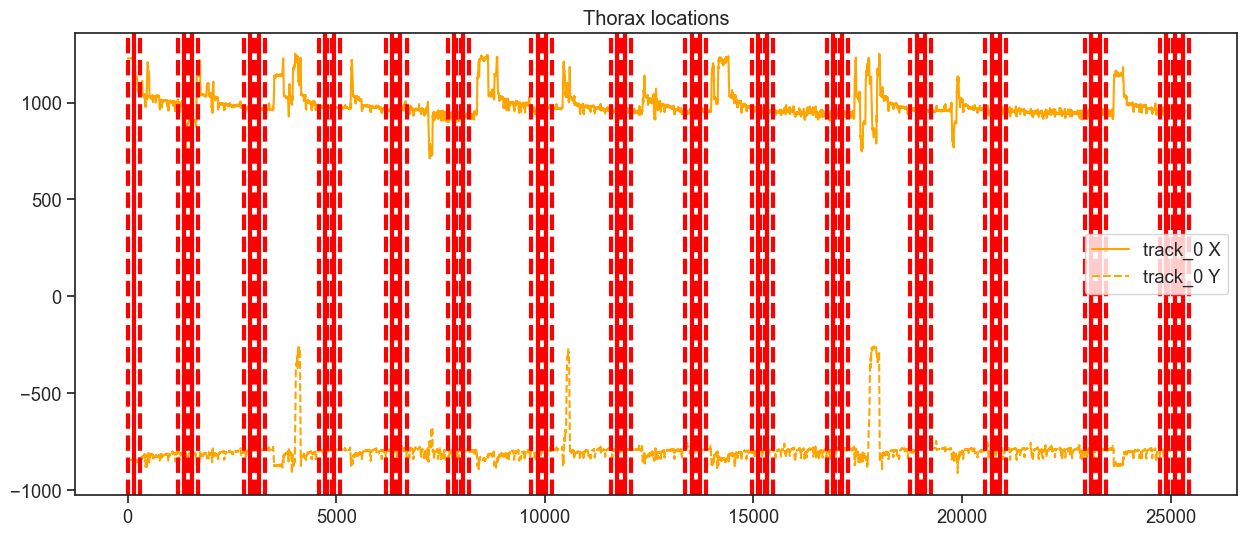

In [46]:
fig, ax = plt.subplots()

plt.plot(body_part_to_loc["thorax"][:,0,0], c='orange', label='{} X'.format(track_names[0]))

plt.plot(-1*body_part_to_loc["thorax"][:,1,0], c='orange', linestyle="--", label="{} Y".format(track_names[0]))

for index, row in tone_start_only_df.dropna(subset="filled_frame_number").iterrows():
    plt.axvline(x=row["20_second_before"], color="red", linestyle="--", linewidth=3)
    plt.axvline(x=row["20_second_after"], color="red", linestyle="--", linewidth=3)

    plt.axvline(x=row["filled_frame_number"], color="red", linewidth=3)

plt.legend(loc="center right")
plt.title('Thorax locations')




In [48]:
x_min = 4500

Text(0.5, 1.0, 'Thorax locations')

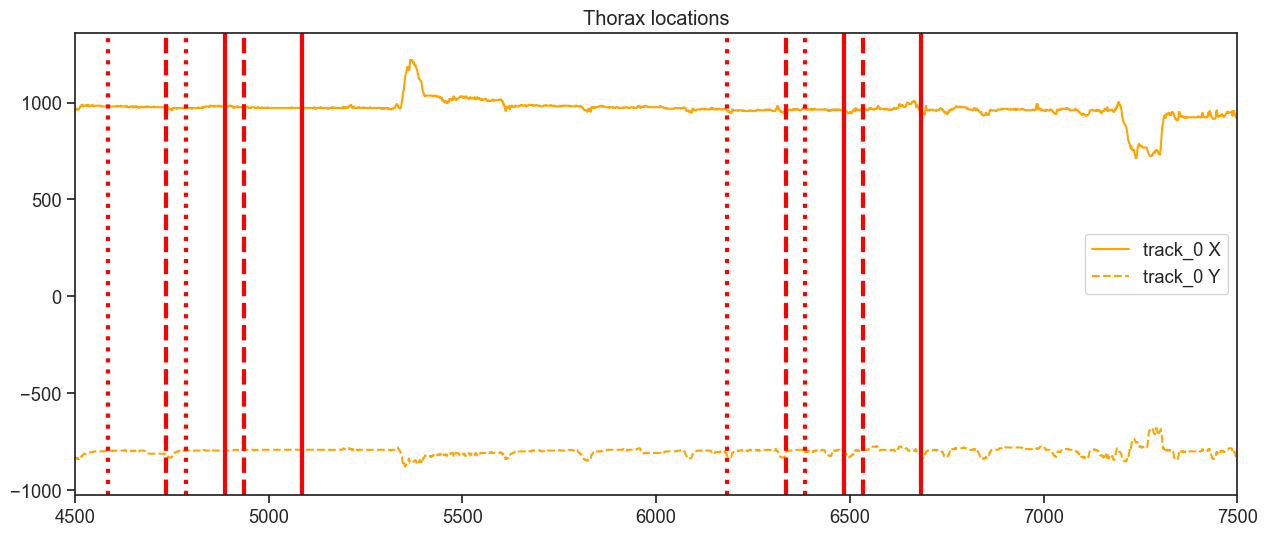

In [51]:
fig, ax = plt.subplots()

plt.plot(body_part_to_loc["thorax"][:,0,0], c='orange', label='{} X'.format(track_names[0]))

plt.plot(-1*body_part_to_loc["thorax"][:,1,0], c='orange', linestyle="--", label="{} Y".format(track_names[0]))

for index, row in tone_start_only_df.dropna(subset="filled_frame_number").iterrows():
    plt.axvline(x=row["20_second_before"], color="red", linestyle=":", linewidth=3)
    plt.axvline(x=row["20_second_after"], color="red", linestyle="-", linewidth=3)

    plt.axvline(x=row["filled_frame_number"], color="red", linestyle="--", linewidth=3)

plt.xlim(x_min, x_min + 3000)
    
plt.legend(loc="center right")
plt.title('Thorax locations')

Text(0.5, 1.0, 'Thorax tracks')

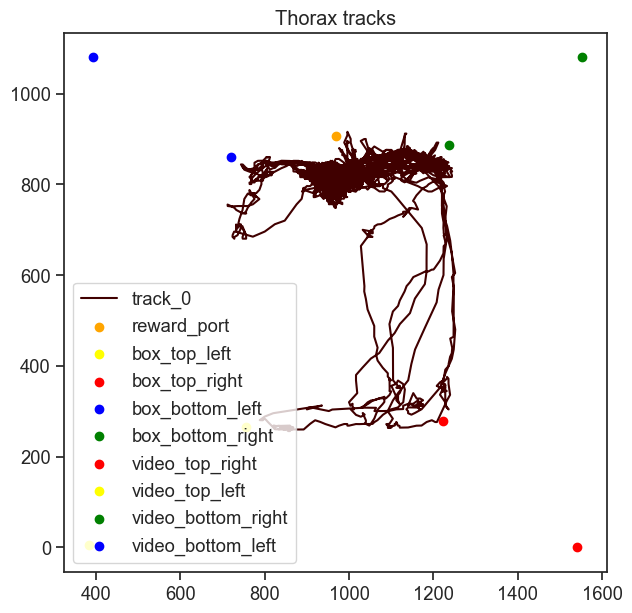

In [53]:
plt.figure(figsize=(7,7))



plt.plot(body_part_to_loc["thorax"][:,0,0],body_part_to_loc["thorax"][:,1,0], c='#400000',label="{}".format(track_names[0]))


for name, coordinate in node_name_to_coordinates.items():
    corner_direction = name.strip("box").strip("video").strip("_")
    plt.scatter(coordinate[0], coordinate[1], label=name, c=corner_to_color[corner_direction])
    
    
plt.legend()

plt.title('Thorax tracks')

# Calculating the distances from the port to the thorax

### Example

- example with one frame and one animal
    - need to use flatten because arrays are in different orientations

In [54]:
body_part_to_loc["thorax"][0,0,:].flatten()

array([1228.16040039])

In [55]:
node_name_to_coordinates["reward_port"].flatten()

array([968.26515974, 907.14479439])

### Steps to take

- Get the x-coordinate of the reward port

In [57]:
reward_port_x_coordinate = node_name_to_coordinates["reward_port"][0]

In [58]:
reward_port_x_coordinate

array([968.26515974])

- Get the y-coordinate of the reward port

In [59]:
reward_port_y_coordinate = node_name_to_coordinates["reward_port"][1]

In [60]:
reward_port_y_coordinate

array([907.14479439])

- Get all the thorax coordinates for the 0th mouse

In [62]:
mouse_0_thorax = body_part_to_loc["thorax"][:,:,0]
# mouse_1_thorax = body_part_to_loc["thorax"][:,:,1]

In [63]:
mouse_0_thorax

array([[1228.16040039,  843.96142578],
       [1228.16040039,  843.96142578],
       [1228.16040039,  843.96142578],
       ...,
       [ 959.8237915 ,  791.78588867],
       [ 948.15484619,  788.296875  ],
       [ 948.15783691,  788.29571533]])

- Get the x and y coordinates for the thorax

In [64]:
mouse_0_thorax_x = mouse_0_thorax[:, 0]
mouse_0_thorax_y = mouse_0_thorax[:, 1]

In [65]:
mouse_0_thorax_x

array([1228.16040039, 1228.16040039, 1228.16040039, ...,  959.8237915 ,
        948.15484619,  948.15783691])

In [66]:
mouse_0_thorax_y

array([843.96142578, 843.96142578, 843.96142578, ..., 791.78588867,
       788.296875  , 788.29571533])

- Calculating the distance for all the frames in both mice

In [67]:
mouse_0_thorax_to_reward_port = ((mouse_0_thorax_x - reward_port_x_coordinate) ** 2 + (mouse_0_thorax_y - reward_port_y_coordinate) ** 2) ** 0.5

In [68]:
mouse_0_thorax_to_reward_port

array([267.46527659, 267.46527659, 267.46527659, ..., 115.66734122,
       120.53734962, 120.53799411])

- Turning this into a function

In [69]:
def get_distance_of_array_to_point(node_from_single_subject_arr, location_coordinate):
    """
    """
    x_difference = node_from_single_subject_arr[:,0] - location_coordinate[0]
    y_difference = node_from_single_subject_arr[:,1] - location_coordinate[1]
    return ((x_difference)**2 + (y_difference)**2)**0.5

In [70]:
mouse_0_thorax_to_reward_port = get_distance_of_array_to_point(mouse_0_thorax, node_name_to_coordinates["reward_port"])

In [71]:
# mouse_1_thorax_to_reward_port = get_distance_of_array_to_point(mouse_1_thorax, node_name_to_coordinates["reward_port"])

In [72]:
mouse_0_thorax_to_reward_port

array([267.46527659, 267.46527659, 267.46527659, ..., 115.66734122,
       120.53734962, 120.53799411])

In [73]:
tone_df.head()

,voltage_time_stamp,frame_number,PosTimestamp,video_time,video_seconds,filled_voltage_time_stamp,filled_frame_number,filled_PosTimestamp,filled_video_time,filled_video_seconds,time,state,trial_number,filled_state,filled_trial_number,20_second_before,20_second_after
0,3680870,NaN,NaN,NaN,NaN,3680870,NaN,NaN,NaN,NaN,3680870.0,1.0,1.0,1.0,1.0,NaN,NaN
1,3680871,NaN,NaN,NaN,NaN,3680871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
2,3680872,NaN,NaN,NaN,NaN,3680872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
3,3680873,NaN,NaN,NaN,NaN,3680873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
4,3680874,NaN,NaN,NaN,NaN,3680874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN


Text(0.5, 1.0, 'Thorax to Reward Port Distance')

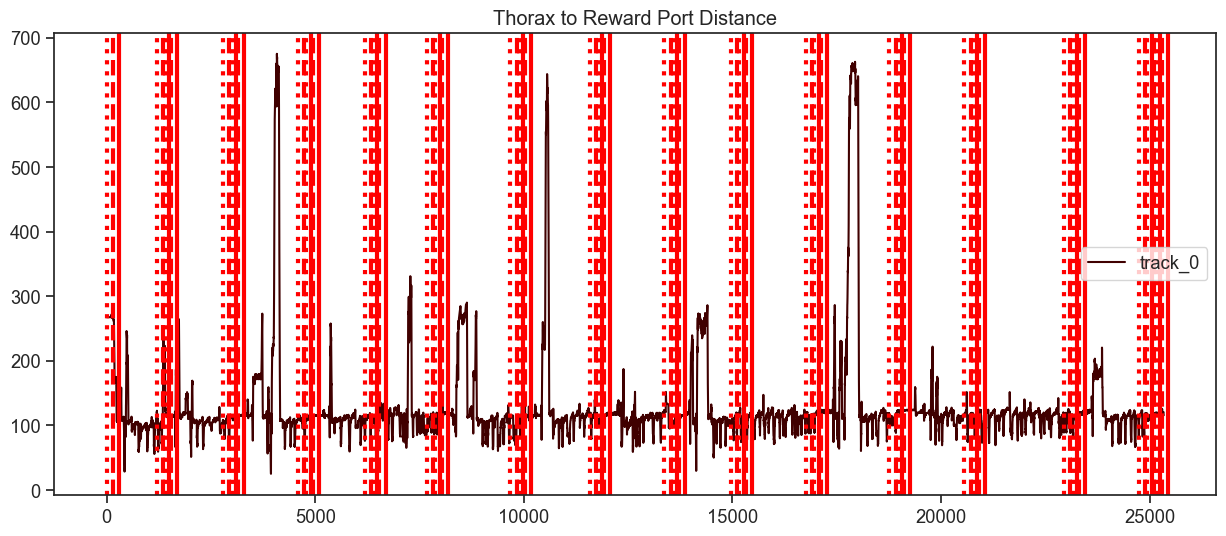

In [75]:
fig, ax = plt.subplots()

plt.plot(mouse_0_thorax_to_reward_port, c='#400000', label='{}'.format(track_names[0]))
# plt.plot(mouse_1_thorax_to_reward_port, c='#001620', label='{}'.format(track_names[1]))
for index, row in tone_start_only_df.dropna(subset="filled_frame_number").iterrows():
    plt.axvline(x=row["20_second_before"], color="red", linestyle=":", linewidth=3)
    plt.axvline(x=row["20_second_after"], color="red", linestyle="-", linewidth=3)

    plt.axvline(x=row["filled_frame_number"], color="red", linestyle="--", linewidth=3)

plt.legend(loc="center right")
plt.title('Thorax to Reward Port Distance')

In [76]:
x_min = 9500

In [77]:
x_range = 6000

Text(0.5, 1.0, 'Thorax to Reward Port Distance')

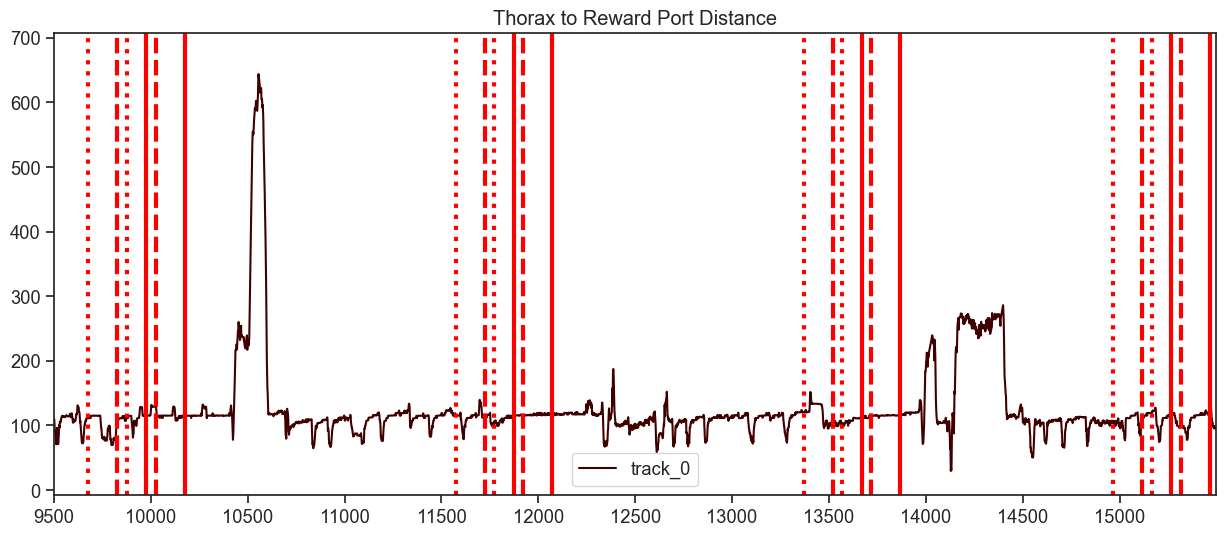

In [79]:
fig, ax = plt.subplots()

plt.plot(mouse_0_thorax_to_reward_port, c='#400000', label='{}'.format(track_names[0]))

for index, row in tone_start_only_df.dropna(subset="filled_frame_number").iterrows():
    plt.axvline(x=row["20_second_before"], color="red", linestyle=":", linewidth=3)
    plt.axvline(x=row["20_second_after"], color="red", linestyle="-", linewidth=3)

    plt.axvline(x=row["filled_frame_number"], color="red", linestyle="--", linewidth=3)

plt.xlim(x_min, x_min + x_range)
plt.xticks(np.arange(x_min, x_min + x_range, 500))

plt.legend()
plt.title('Thorax to Reward Port Distance')


## More advanced visualizations

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

# Calculating the velocity to the port

In [80]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
#     return node_loc_vel
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

In [81]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

- We need to multiply one of the x-coordinates for one of the mouse by -1 to account for reflecting side

In [83]:
mouse_0_thorax_to_port_velocity = moving_average(np.diff(mouse_0_thorax_to_reward_port, prepend=mouse_0_thorax_to_reward_port[0]), n=3) * -1
# mouse_1_thorax_to_port_velocity = moving_average(np.diff(mouse_1_thorax_to_reward_port, prepend=mouse_1_thorax_to_reward_port[0]), n=3) * -1


Text(0.5, 1.0, 'Thorax to Reward Port Velocity')

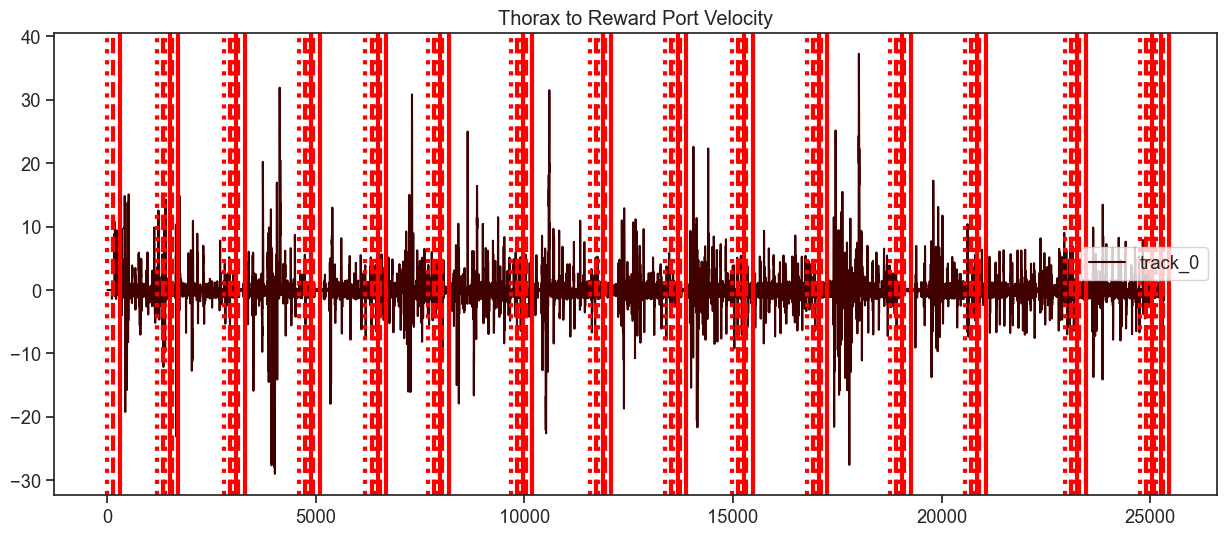

In [85]:
fig, ax = plt.subplots()

plt.plot(mouse_0_thorax_to_port_velocity, c='#400000', label='{}'.format(track_names[0]))
# plt.plot(mouse_1_thorax_to_port_velocity, c='#001620', label='{}'.format(track_names[1]))

for index, row in tone_start_only_df.dropna(subset="filled_frame_number").iterrows():
    plt.axvline(x=row["20_second_before"], color="red", linestyle=":", linewidth=3)
    plt.axvline(x=row["20_second_after"], color="red", linestyle="-", linewidth=3)

    plt.axvline(x=row["filled_frame_number"], color="red", linestyle="--", linewidth=3)

    
    
plt.legend(loc="center right")
plt.title('Thorax to Reward Port Velocity')

Text(0.5, 1.0, 'Thorax to Reward Port Velocity')

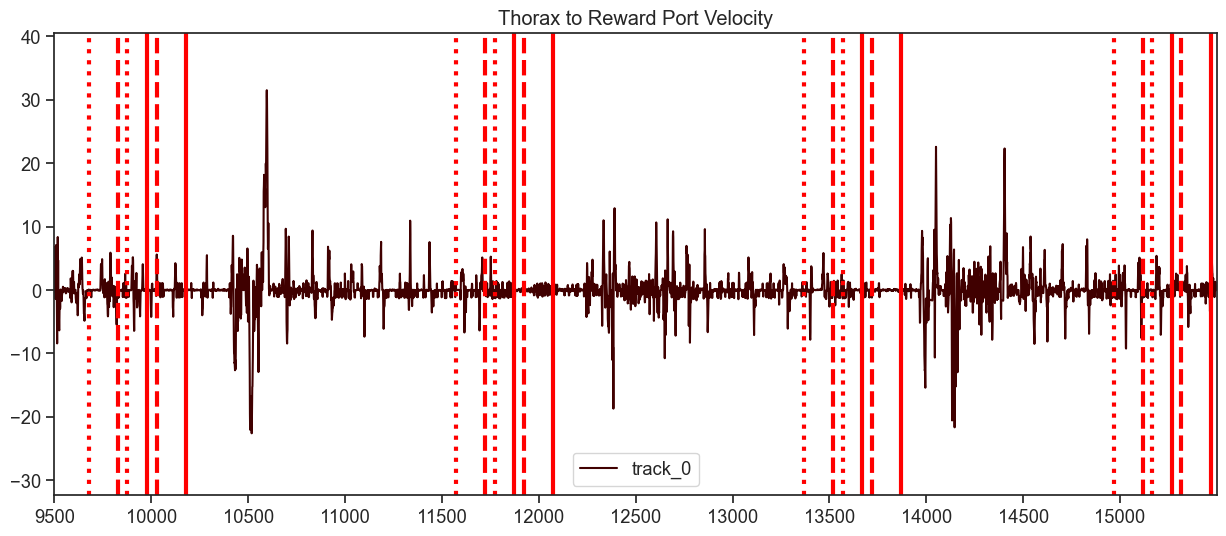

In [86]:


fig, ax = plt.subplots()

plt.plot(mouse_0_thorax_to_port_velocity, c='#400000', label='{}'.format(track_names[0]))
# plt.plot(mouse_1_thorax_to_port_velocity, c='#001620', label='{}'.format(track_names[1]))

for index, row in tone_start_only_df.dropna(subset="filled_frame_number").iterrows():
    plt.axvline(x=row["20_second_before"], color="red", linestyle=":", linewidth=3)
    plt.axvline(x=row["20_second_after"], color="red", linestyle="-", linewidth=3)

    plt.axvline(x=row["filled_frame_number"], color="red", linestyle="--", linewidth=3)

plt.xlim(x_min, x_min + x_range)
plt.xticks(np.arange(x_min, x_min + x_range, 500))

plt.legend()
plt.title('Thorax to Reward Port Velocity')

# TODO: Making Histograms

In [87]:
tone_df

,voltage_time_stamp,frame_number,PosTimestamp,video_time,video_seconds,filled_voltage_time_stamp,filled_frame_number,filled_PosTimestamp,filled_video_time,filled_video_seconds,time,state,trial_number,filled_state,filled_trial_number,20_second_before,20_second_after
0,3680870,NaN,NaN,NaN,NaN,3680870,NaN,NaN,NaN,NaN,3680870.0,1.0,1.0,1.0,1.0,NaN,NaN
1,3680871,NaN,NaN,NaN,NaN,3680871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
2,3680872,NaN,NaN,NaN,NaN,3680872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
3,3680873,NaN,NaN,NaN,NaN,3680873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
4,3680874,NaN,NaN,NaN,NaN,3680874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25388554,29063065,NaN,NaN,NaN,NaN,29063065,25335.0,29061683.0,1809.642857,1809.0,NaN,NaN,NaN,1.0,16.0,25185.0,25485.0
25388555,29063066,NaN,NaN,NaN,NaN,29063066,25335.0,29061683.0,1809.642857,1809.0,NaN,NaN,NaN,1.0,16.0,25185.0,25485.0
25388556,29063067,NaN,NaN,NaN,NaN,29063067,25335.0,29061683.0,1809.642857,1809.0,NaN,NaN,NaN,1.0,16.0,25185.0,25485.0
25388557,29063068,NaN,NaN,NaN,NaN,29063068,25335.0,29061683.0,1809.642857,1809.0,NaN,NaN,NaN,1.0,16.0,25185.0,25485.0


In [100]:
example_tone_frame = tone_start_only_df[tone_start_only_df["filled_state"] >= 1]["filled_frame_number"].iloc[1]

In [103]:
tone_start_only_df["filled_frame_number"].max() / 14

1806.9285714285713

In [101]:
example_tone_frame

1343.0

In [105]:
for num in range(-4,0):
    print(num * 14, (num + 1) * 14)

-56 -42
-42 -28
-28 -14
-14 0


In [106]:
for num in range(0, 5):
    print(num * 14, (num + 1) * 14)

0 14
14 28
28 42
42 56
56 70


In [89]:
mouse_0_thorax_to_reward_port

array([267.46527659, 267.46527659, 267.46527659, ..., 115.66734122,
       120.53734962, 120.53799411])

In [88]:
mouse_0_thorax_to_port_velocity

array([-0.        , -0.        , -0.        , ...,  0.01281332,
       -1.62128679, -1.63808818])

## Adding the trial information

# OLD STUFF BELOW

In [58]:
mouse_0_thorax_to_port_velocity

array([-0.        , -0.        , -0.        , ...,  0.96025097,
        1.00941397,  1.07827144])

In [59]:
thx_vel_mouse_left.shape

NameError: name 'thx_vel_mouse_left' is not defined

In [ ]:
thx_vel_mouse_right.shape

In [ ]:
thx_acc_mouse_left = moving_average(np.diff(thx_vel_mouse_left, prepend=thx_vel_mouse_left[0]), n=1)
thx_acc_mouse_right = moving_average(np.diff(thx_vel_mouse_right, prepend=thx_vel_mouse_right[0]), n=1)

In [ ]:
thx_acc_mouse_left.shape

In [ ]:
thx_acc_mouse_right.shape

- Thorax Distance

In [ ]:
thx_distance = np.absolute(body_part_to_loc["thorax"][:, 0, 0] - body_part_to_loc["thorax"][:, 0, 1])[1:-1]

In [ ]:
thx_distance.shape

### Visualizing thorax x-y dynamics and velocity for fly 0

In [ ]:
thx_vel_mouse_left[:10]

In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thx_vel_mouse_left, 'k', label='x')
ax1.legend()
ax1.set_xticks([])
plt.axhline(y=0, color='r', linestyle='-')
ax1.set_title('Thorax Velocity')


In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thx_acc_mouse_left, 'k', label='x')
ax1.legend()
ax1.set_xticks([])
plt.axhline(y=0, color='r', linestyle='-')
ax1.set_title('Thorax Acceleration')


In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thx_vel_mouse_right, 'k', label='x')
ax1.legend()
ax1.set_xticks([])
plt.axhline(y=0, color='r', linestyle='-')
ax1.set_title('Thorax Velocity')


In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thx_acc_mouse_right, 'k', label='x')
ax1.legend()
ax1.set_xticks([])
plt.axhline(y=0, color='r', linestyle='-')
ax1.set_title('Thorax Acceleration')

# Clustering with UMAP

In [ ]:
reducer = umap.UMAP()

In [ ]:
all_vel_acc = np.vstack([thx_vel_mouse_left, thx_vel_mouse_right, thx_acc_mouse_left, thx_acc_mouse_right, thx_distance]).T


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaled_vel_acc = StandardScaler().fit_transform(all_vel_acc)


In [ ]:
all_vel_acc.shape

In [ ]:
scaled_vel_acc.shape

In [ ]:
embedding = reducer.fit_transform(scaled_vel_acc)

In [ ]:
embedding.shape

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
#     c=[sns.color_palette()[x] for x in penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24);

In [ ]:
from io import BytesIO
from PIL import Image
import base64

In [ ]:
import cv2
from PIL import Image

- Putting all the images to file

In [ ]:
video_path="./data/cd1_predicted_frames/CAGE4_TUBETEST_1v2.fixed.mp4"

In [ ]:
vidcap = cv2.VideoCapture(video_path)
success, image = vidcap.read()
image = cv2.resize(image, (0,0), fx=0.5, fy=0.5) 
count = 0
index_to_file_path = {}
while success:
    try:
        index_to_file_path[count] = "./data/example_frames/frame{}.jpg".format(count)    
        cv2.imwrite(index_to_file_path[count], image)     # save frame as JPEG file      
        success, image = vidcap.read()
        image = cv2.resize(image, (0,0), fx=0.1, fy=0.1) 
        count += 1
    except:
        print("error with {}".format(index_to_file_path[count]))


In [ ]:
frame_number = 5

In [ ]:
cap = cv2.VideoCapture("./data/cd1_predicted_frames/CAGE4_TUBETEST_1v2.fixed.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
res, frame = cap.read()

In [ ]:
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [ ]:
length

In [ ]:
Image.fromarray(frame)

In [ ]:
type(Image.fromarray(frame))

In [ ]:
embedding[:,0]

In [ ]:
embedding[:,0].shape[0]

In [ ]:
"./Screenshotfrom2023-03-1013-06-39.png"

In [ ]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool

output_file("toolbar.html")

source = ColumnDataSource(
        data=dict(
            x=embedding[:,0],
            y=embedding[:,1],
            imgs = ["{}".format(index_to_file_path[index]) for index in range(embedding[:,0].shape[0])]
        )
    )

hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <img
                    src="@imgs" height="160" alt="@imgs" width="160"
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                ></img>
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">@desc</span>
                <span style="font-size: 15px; color: #966;">[$index]</span>
            </div>
            <div>
                <span style="font-size: 15px;">Location</span>
                <span style="font-size: 10px; color: #696;">($x, $y)</span>
            </div>
        </div>
        """
    )

p = figure(tools=[hover],
           title="Mouse over the dots")

p.circle('x', 'y', size=20, source=source)

show(p)

In [ ]:
res

## Loading the data

We use the [h5py](https://www.h5py.org) package to load data from the HDF5. This is already installed in Colab. If your running analysis code on your local machine and have SLEAP installed, then `h5py` and other packages we use are already installed in your SLEAP conda environment. Otherwise, you may need to use `conda` or `pip` to install `h5py` as well as `numpy`, `scipy`, `matplotlib`, `seaborn`, and any other packages you want use in your analysis code.

Let's load the file and take a peek.

In [ ]:
import h5py
import numpy as np

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()


In our example file, the shape of the locations matrix (the `tracks` dataset) is (3000, 13, 2, 2) **after it is transposed** (with the `.T`). We transpose the data when loading it in Python; no transpose is needed when using MATLAB. This is because Python and MATLAB expect matrices to be stored differently.

Here's what each dimension of the matrix means:

- 3000: the number of frames;

- 13: the number of nodes in the skeleton (we've also loaded and displayed the `node_names` dataset with the names of these 13 nodes);

- 2: for the x and y coordinates;

- 2: the number of distinct animal identities which were found (we have 2 flies in the video clip and they were tracked perfectly, so we ended up with exactly 2 track, but there may be more tracks than animals if tracking didn't work as well).

We can get these counts from the shape of the matrix, like so:


In [ ]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

Now that we've loaded the data, let's see some different things we can do with it...

## Fill missing values

In [ ]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [ ]:
locations = fill_missing(locations)

## Visualize thorax movement across video

In [ ]:
node_names

In [ ]:
body_part_to_loc = {}
for index, body_part in enumerate(node_names):
    body_part_to_loc[body_part] = locations[:, index, :, :]

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

### SLEAP Coordinates


In [ ]:
body_part_to_loc["thorax"]

In [ ]:
fig, ax = plt.subplots()

plt.plot(body_part_to_loc["thorax"][:,0,0], c='orange', label='Left Mouse X')
plt.plot(body_part_to_loc["thorax"][:,0,1], c='blue', label='Right Mouse X')

plt.plot(-1*body_part_to_loc["thorax"][:,1,0], c='orange', linestyle="--", label="Left Mouse Y")
plt.plot(-1*body_part_to_loc["thorax"][:,1,1], c='blue', linestyle="--", label="Right Mouse Y")

plt.legend(loc="center right")
plt.title('Thorax locations')




In [ ]:
plt.figure(figsize=(7,7))
plt.plot(body_part_to_loc["thorax"][:,0,0],body_part_to_loc["thorax"][:,1,0], 'orange',label='Left Mouse')
plt.plot(body_part_to_loc["thorax"][:,0,1],body_part_to_loc["thorax"][:,1,1], 'blue',label='Right Mouse')
plt.legend()

# plt.xticks([])

plt.title('Thorax tracks')

## More advanced visualizations

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

In [ ]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
#     return node_loc_vel
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

There are two flies. Let's get results for each separately.

- We need to multiply one of the x-coordinates for one of the mouse by -1 to account for reflecting side

In [ ]:
thx_vel_mouse_left = moving_average(np.diff(body_part_to_loc["thorax"][:, 0, 0], prepend=body_part_to_loc["thorax"][:, 0, 0][0]), n=3)
thx_vel_mouse_right = moving_average(np.diff(-1*body_part_to_loc["thorax"][:, 0, 1], prepend=body_part_to_loc["thorax"][:, 0, 1][0]), n=3)

In [ ]:
thx_vel_mouse_left.shape

In [ ]:
thx_vel_mouse_right.shape

In [ ]:
thx_acc_mouse_left = moving_average(np.diff(thx_vel_mouse_left, prepend=thx_vel_mouse_left[0]), n=1)
thx_acc_mouse_right = moving_average(np.diff(thx_vel_mouse_right, prepend=thx_vel_mouse_right[0]), n=1)

In [ ]:
thx_acc_mouse_left.shape

In [ ]:
thx_acc_mouse_right.shape

- Thorax Distance

In [ ]:
thx_distance = np.absolute(body_part_to_loc["thorax"][:, 0, 0] - body_part_to_loc["thorax"][:, 0, 1])[1:-1]

In [ ]:
thx_distance.shape

### Visualizing thorax x-y dynamics and velocity for fly 0

In [ ]:
thx_vel_mouse_left[:10]

In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thx_vel_mouse_left, 'k', label='x')
ax1.legend()
ax1.set_xticks([])
plt.axhline(y=0, color='r', linestyle='-')
ax1.set_title('Thorax Velocity')


In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thx_acc_mouse_left, 'k', label='x')
ax1.legend()
ax1.set_xticks([])
plt.axhline(y=0, color='r', linestyle='-')
ax1.set_title('Thorax Acceleration')


In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thx_vel_mouse_right, 'k', label='x')
ax1.legend()
ax1.set_xticks([])
plt.axhline(y=0, color='r', linestyle='-')
ax1.set_title('Thorax Velocity')


In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thx_acc_mouse_right, 'k', label='x')
ax1.legend()
ax1.set_xticks([])
plt.axhline(y=0, color='r', linestyle='-')
ax1.set_title('Thorax Acceleration')

Now that we've loaded the data, let's see some different things we can do with it...

## Fill missing values

In [ ]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [ ]:
locations = fill_missing(locations)

## Visualize thorax movement across video

In [ ]:
node_names

In [ ]:
body_part_to_loc = {}
for index, body_part in enumerate(node_names):
    body_part_to_loc[body_part] = locations[:, index, :, :]

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

### SLEAP Coordinates


In [ ]:
body_part_to_loc["thorax"]

In [ ]:
fig, ax = plt.subplots()

plt.plot(body_part_to_loc["thorax"][:,0,0], c='orange', label='Left Mouse X')
plt.plot(body_part_to_loc["thorax"][:,0,1], c='blue', label='Right Mouse X')

plt.plot(-1*body_part_to_loc["thorax"][:,1,0], c='orange', linestyle="--", label="Left Mouse Y")
plt.plot(-1*body_part_to_loc["thorax"][:,1,1], c='blue', linestyle="--", label="Right Mouse Y")

plt.legend(loc="center right")
plt.title('Thorax locations')




In [ ]:
plt.figure(figsize=(7,7))
plt.plot(body_part_to_loc["thorax"][:,0,0],body_part_to_loc["thorax"][:,1,0], 'orange',label='Left Mouse')
plt.plot(body_part_to_loc["thorax"][:,0,1],body_part_to_loc["thorax"][:,1,1], 'blue',label='Right Mouse')
plt.legend()

# plt.xticks([])

plt.title('Thorax tracks')

## More advanced visualizations

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

In [ ]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
#     return node_loc_vel
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

There are two flies. Let's get results for each separately.

- We need to multiply one of the x-coordinates for one of the mouse by -1 to account for reflecting side

In [ ]:
thx_vel_mouse_left = moving_average(np.diff(body_part_to_loc["thorax"][:, 0, 0], prepend=body_part_to_loc["thorax"][:, 0, 0][0]), n=3)
thx_vel_mouse_right = moving_average(np.diff(-1*body_part_to_loc["thorax"][:, 0, 1], prepend=body_part_to_loc["thorax"][:, 0, 1][0]), n=3)

In [ ]:
thx_vel_mouse_left.shape

In [ ]:
thx_vel_mouse_right.shape

In [ ]:
thx_acc_mouse_left = moving_average(np.diff(thx_vel_mouse_left, prepend=thx_vel_mouse_left[0]), n=1)
thx_acc_mouse_right = moving_average(np.diff(thx_vel_mouse_right, prepend=thx_vel_mouse_right[0]), n=1)

In [ ]:
thx_acc_mouse_left.shape

In [ ]:
thx_acc_mouse_right.shape

- Thorax Distance

In [ ]:
thx_distance = np.absolute(body_part_to_loc["thorax"][:, 0, 0] - body_part_to_loc["thorax"][:, 0, 1])[1:-1]

In [ ]:
thx_distance.shape

### Visualizing thorax x-y dynamics and velocity for fly 0

In [ ]:
thx_vel_mouse_left[:10]

In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thx_vel_mouse_left, 'k', label='x')
ax1.legend()
ax1.set_xticks([])
plt.axhline(y=0, color='r', linestyle='-')
ax1.set_title('Thorax Velocity')


In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thx_acc_mouse_left, 'k', label='x')
ax1.legend()
ax1.set_xticks([])
plt.axhline(y=0, color='r', linestyle='-')
ax1.set_title('Thorax Acceleration')


In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thx_vel_mouse_right, 'k', label='x')
ax1.legend()
ax1.set_xticks([])
plt.axhline(y=0, color='r', linestyle='-')
ax1.set_title('Thorax Velocity')


In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thx_acc_mouse_right, 'k', label='x')
ax1.legend()
ax1.set_xticks([])
plt.axhline(y=0, color='r', linestyle='-')
ax1.set_title('Thorax Acceleration')

# Penguins Test

In [ ]:
penguins = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
penguins.head()

In [ ]:
penguin_data = penguins[
    [
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
].values

In [ ]:
penguin_data.shape

# Clustering with UMAP

In [ ]:
reducer = umap.UMAP()

In [ ]:
all_vel_acc = np.vstack([thx_vel_mouse_left, thx_vel_mouse_right, thx_acc_mouse_left, thx_acc_mouse_right, thx_distance]).T


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaled_vel_acc = StandardScaler().fit_transform(all_vel_acc)


In [ ]:
all_vel_acc.shape

In [ ]:
scaled_vel_acc.shape

In [ ]:
embedding = reducer.fit_transform(scaled_vel_acc)

In [ ]:
embedding.shape

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
#     c=[sns.color_palette()[x] for x in penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24);

In [ ]:
from io import BytesIO
from PIL import Image
import base64

In [ ]:
import cv2
from PIL import Image

- Putting all the images to file

In [ ]:
video_path="./data/cd1_predicted_frames/CAGE4_TUBETEST_1v2.fixed.mp4"

In [ ]:
vidcap = cv2.VideoCapture(video_path)
success, image = vidcap.read()
image = cv2.resize(image, (0,0), fx=0.5, fy=0.5) 
count = 0
index_to_file_path = {}
while success:
    try:
        index_to_file_path[count] = "./data/example_frames/frame{}.jpg".format(count)    
        cv2.imwrite(index_to_file_path[count], image)     # save frame as JPEG file      
        success, image = vidcap.read()
        image = cv2.resize(image, (0,0), fx=0.1, fy=0.1) 
        count += 1
    except:
        print("error with {}".format(index_to_file_path[count]))


In [ ]:
frame_number = 5

In [ ]:
cap = cv2.VideoCapture("./data/cd1_predicted_frames/CAGE4_TUBETEST_1v2.fixed.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
res, frame = cap.read()

In [ ]:
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [ ]:
length

In [ ]:
Image.fromarray(frame)

In [ ]:
type(Image.fromarray(frame))

In [ ]:
embedding[:,0]

In [ ]:
embedding[:,0].shape[0]

In [ ]:
"./Screenshotfrom2023-03-1013-06-39.png"

In [ ]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool

output_file("toolbar.html")

source = ColumnDataSource(
        data=dict(
            x=embedding[:,0],
            y=embedding[:,1],
            imgs = ["{}".format(index_to_file_path[index]) for index in range(embedding[:,0].shape[0])]
        )
    )

hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <img
                    src="@imgs" height="160" alt="@imgs" width="160"
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                ></img>
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">@desc</span>
                <span style="font-size: 15px; color: #966;">[$index]</span>
            </div>
            <div>
                <span style="font-size: 15px;">Location</span>
                <span style="font-size: 10px; color: #696;">($x, $y)</span>
            </div>
        </div>
        """
    )

p = figure(tools=[hover],
           title="Mouse over the dots")

p.circle('x', 'y', size=20, source=source)

show(p)

# Clustering with all videos

In [ ]:
raise ValueError

In [ ]:
all_file_predicted_coordinates = sorted(glob.glob("./data/cd1_predicted_frames/analysis_h5/*.h5"))

In [ ]:
all_file_videos = sorted(glob.glob("./data/cd1_predicted_frames/*.mp4"))

In [ ]:
all_file_predicted_coordinates[:5]

In [ ]:
all_file_videos[:5]

In [ ]:
video_basename_to_h5_and_video = defaultdict(dict)
for video_path in all_file_videos:
    video_basename = os.path.basename(video_path)
    video_fileroot = video_basename.split(".")[0]
    video_basename_to_h5_and_video[video_fileroot]["video_path"] = video_path
    # getting h5 file
    video_basename_to_h5_and_video[video_fileroot]["h5_path"] = [path for path in all_file_predicted_coordinates if video_fileroot in path][0]

In [ ]:
video_basename_to_h5_and_video